In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData


import scipy


In [2]:
PRE_INTERVAL = 500
POST_INTERVAL = 500
INTERVAL_SIZE = 50
SMOOTH = 1
EVENT = "CrossFixation"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"

In [3]:
test_accs = np.load(os.path.join(OUTPUT_DIR, "intertrial_agg_max_feat_test_accs.npy")).reshape((-1))
train_accs = np.load(os.path.join(OUTPUT_DIR, "intertrial_agg_max_feat_train_accs.npy")).reshape((-1))
shuffle_accs = np.load(os.path.join(OUTPUT_DIR, "intertrial_agg_max_feat_shuffle_{shuffle_seed}_test_accs.npy")).reshape((-1))

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:0'` for same effect.
  warnings.warn(msg, FutureWarning)


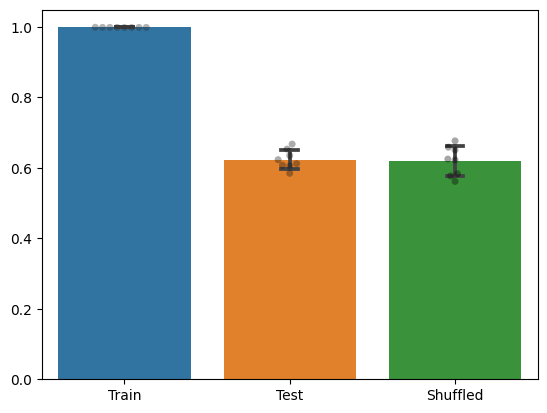

In [4]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_bars([train_accs, test_accs, shuffle_accs], ["Train", "Test", "Shuffled"], ax)